<a href="https://colab.research.google.com/github/2series/rockwall_analytics/blob/master/winery_s1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a wineRatingPredictor
## Part 1: Data Integration, Cleaning, Transformation, Reduction, Discretization and more
## 14 May 2020
## About RIHAD VARIAWA
> As a Data Scientist and former head of global fintech research at Malastare.ai, I find fulfillment tacking challenges to solve complex problems using data

![](https://media.giphy.com/media/3ohhwpzf1EmlkTUsO4/giphy.gif)

ML workflow to building a **wineRantingPredictor**:

1. Data Preprocessing
2. EDA
3. Feature Engineering & Feature Selection
4. Set Evaluation Metric & Establish Baseline
5. Selecting Models based on Evaluation Metric
6. Perform Hyperparameter Tuning on Selected Model
7. Train & Evaluate the Model
8. Interpret Model Predictions
9. Draw Conclusions

Lastly, I'll deploy the model using *Docker and Luigi*

## This notebook covers steps 1 to 3

The objective of the project is to construct a model using a sample dataset to illustrate how good predictions are possible, perhaps as a proof of concept for a larger project. I am going to use the results of the model to confirm that ML applications are effective solutions to business use cases such as optimizing a wine portfolio

I should keep in mind that the **Science** in Data Science serves a purpose, ultimately for a non-scientist.
 
A typical project has some implied base requirements:

1. It should be UNDERSTANDABLE to the audience, as its likely they have limited knowledge of *Statistics and Machine Learning*
2. It should be SCALABLE, as a complete deployable dataset could have millions of records
3. It should be AUTOMATED in a way that it can run on any **Deployment System** without requiring specialized config and setups

In [33]:
!pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.2.2)


In [0]:
# data manipulation libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
# to enable high resolution plots

# feature extraction and preprocessing
import re
import datetime

# feature transformation and preprocessing
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# to bypass warnings in section 2.5.
import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_csv('wine_dataset.csv')
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Fragrances suggest hay, crushed tomato vine an...",Kirchleiten,90,30.0,Northeastern Italy,Alto Adige,NaN,Kerin O’Keefe,@kerinokeefe,Tiefenbrunner 2012 Kirchleiten Sauvignon (Alto...,Sauvignon,Tiefenbrunner
1,1,France,"Packed with fruit and crisp acidity, this is a...",NaN,87,22.0,Loire Valley,Sancerre,NaN,Roger Voss,@vossroger,Bernard Reverdy et Fils 2014 Rosé (Sancerre),Rosé,Bernard Reverdy et Fils
2,2,Italy,"This easy, ruby-red wine displays fresh berry ...",NaN,86,NaN,Tuscany,Chianti Classico,NaN,NaN,NaN,Dievole 2009 Chianti Classico,Sangiovese,Dievole
3,3,US,Pretty in violet and rose petals this is a low...,Horseshoe Bend Vineyard,92,50.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Davis Family 2012 Horseshoe Bend Vineyard Pino...,Pinot Noir,Davis Family
4,4,US,This golden wine confounds in a mix of wet sto...,Dutton Ranch,93,38.0,California,Russian River Valley,Sonoma,Virginie Boone,@vboone,Dutton-Goldfield 2013 Dutton Ranch Chardonnay ...,Chardonnay,Dutton-Goldfield


+ **country**: origin of wine producer
+ **description**: presentment of the taster to describe the wine
+ **designation**: name of the wine given to the wine by the producer, sometimes used interchangeably with vineyard. Usually available in the title
+ **points**: our target variable, representing the score of a particular wine received from a taster. An important remark is, a wine may receive different points from the same taster
+ **price**: price of the wine
+ **region_1**: official definition of the place where the grapes for a wine are grown
+ **region_2**: official definition of the place where the grapes for a wine are grown
+ **taster_name**: the taster assigning points to the wine
+ **title**: name of the wine as displayed on the label
+ **variety**: grape variety of the wine
+ **winery**: name of the wine producer

# 1. Data Preprocessing


In [36]:
train = pd.read_csv('train.csv')
train.sample(5) # similar to head() method

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
2399,Germany,Intentionally skewed toward the drier side of ...,Prüm Blue Kabinett,89,19.0,Mosel,NaN,NaN,Joe Czerwinski,@JoeCz,S.A. Prüm 2009 Prüm Blue Kabinett Riesling (Mo...,Riesling,S.A. Prüm
7834,Italy,"Reserved at first, this Brunello gradually rev...",Riserva,88,90.0,Tuscany,Brunello di Montalcino,NaN,Kerin O’Keefe,@kerinokeefe,Poggio Nardone 2011 Riserva (Brunello di Mont...,Sangiovese,Poggio Nardone
4832,US,Tangy cherry flavors and a lip-smacking textur...,Pinoli Vineyard,93,65.0,California,Anderson Valley,NaN,Jim Gordon,@gordone_cellars,Domaine Anderson 2013 Pinoli Vineyard Pinot No...,Pinot Noir,Domaine Anderson
4729,US,"This wine is tasty, tangy and nervy, bringing ...",Methode a l'Ancienne,91,32.0,California,Anderson Valley,NaN,Jim Gordon,@gordone_cellars,Navarro 2013 Methode a l'Ancienne Pinot Noir (...,Pinot Noir,Navarro
5617,US,"From a selection of vineyard sites and clones,...",Small Town,91,50.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Eric Kent 2013 Small Town Pinot Noir (Sonoma C...,Pinot Noir,Eric Kent


In [37]:
# descriptive statistics + info about dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                8994 non-null   object 
 1   description            9000 non-null   object 
 2   designation            6455 non-null   object 
 3   points                 9000 non-null   int64  
 4   price                  8403 non-null   float64
 5   province               8994 non-null   object 
 6   region_1               7505 non-null   object 
 7   region_2               3469 non-null   object 
 8   taster_name            7223 non-null   object 
 9   taster_twitter_handle  6888 non-null   object 
 10  title                  9000 non-null   object 
 11  variety                9000 non-null   object 
 12  winery                 9000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 914.2+ KB


In [38]:
train.describe()

,points,price
count,9000.000000,8403.000000
mean,88.455222,35.532191
std,3.025945,40.750683
min,80.000000,5.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,1300.000000


In [39]:
test = pd.read_csv('test.csv')
test.sample(5) # similar to head() method

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
245,Chile,"Murky, mulchy aromas of baked black fruits and...",Pedriscal Vineyard Reserva,85,23.0,Elqui Valley,NaN,NaN,Michael Schachner,@wineschach,Falernia 2013 Pedriscal Vineyard Reserva Carme...,Carmenère,Falernia
995,Germany,"Intensely rocky, salty mineral tones abound in...",Weinkellerei,89,13.0,Rheinhessen,NaN,NaN,Anna Lee C. Iijima,NaN,Leonard Kreusch 2016 Weinkellerei Riesling (Rh...,Riesling,Leonard Kreusch
504,France,"Still young, this rich and full-bodied wine is...",Saint-Andelain,91,26.0,Loire Valley,Pouilly-Fumé,NaN,Roger Voss,@vossroger,Domaine des Berthiers 2010 Saint-Andelain (Po...,Sauvignon Blanc,Domaine des Berthiers
980,France,"If a rosé can be serious, this is it. Named af...",Cuvée Patricia Ortelli,90,35.0,Provence,Coteaux Varois en Provence,NaN,Roger Voss,@vossroger,Château la Calisse 2015 Cuvée Patricia Ortelli...,Rosé,Château la Calisse
956,US,"Good, bright, spicy fruit, with fine balance a...",Home Ranch,89,26.0,California,Sonoma County,Sonoma,Paul Gregutt,@paulgwine,Seghesio 1998 Home Ranch Zinfandel (Sonoma Cou...,Zinfandel,Seghesio


In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                1000 non-null   object 
 1   description            1000 non-null   object 
 2   designation            716 non-null    object 
 3   points                 1000 non-null   int64  
 4   price                  920 non-null    float64
 5   province               1000 non-null   object 
 6   region_1               831 non-null    object 
 7   region_2               384 non-null    object 
 8   taster_name            792 non-null    object 
 9   taster_twitter_handle  756 non-null    object 
 10  title                  1000 non-null   object 
 11  variety                1000 non-null   object 
 12  winery                 1000 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 101.7+ KB


Majority of the features are categorical and we have some missing values in both datasets. Algos can only work with numerical and non-empty values. Thus we are going to develop strategies in **feature engineering to impute missing values** and **transform categorical features into the numeric features**

## 1.1 Missing Values in our dataset

The function below will enable us to observe the missing values as a percentage per feature

In [0]:
def missing_values_table(df):
    # total missing values
    mis_val = df.isnull().sum()

    # percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values Missing'})

    # sort the table by percentage of missing descending
    mis_val_table_ren_columns = (mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values Missing', ascending=False).round(1))

    # print some summary information
    print('Your selected dataframe has ' + str(df.shape[1]) + ' columns.\n'
          'There are ' + str(mis_val_table_ren_columns.shape[0]) +
          'columns that have missing values')

    # return the dataframe with missing information
    return mis_val_table_ren_columns

In [42]:
missing_values_table(df) # incl target feature

Your selected dataframe has 14 columns.
There are 8columns that have missing values


,Missing Values,% of Total Values Missing
region_2,6147,61.5
designation,2829,28.3
taster_twitter_handle,2356,23.6
taster_name,1985,19.8
region_1,1664,16.6
price,677,6.8
country,6,0.1
province,6,0.1


Features that have missing values more than 50% will be dropped, as they aren't likely to provide significant information in our model

In this sample dataset, **target variable** has no missing values. If we had some, we would drop all the missing values of the target so not to leak any data or distort the existing distribution of the target

Looking at the missing values, *region_2* will be dropped

In [43]:
missing_values_table(train)

Your selected dataframe has 13 columns.
There are 8columns that have missing values


,Missing Values,% of Total Values Missing
region_2,5531,61.5
designation,2545,28.3
taster_twitter_handle,2112,23.5
taster_name,1777,19.7
region_1,1495,16.6
price,597,6.6
country,6,0.1
province,6,0.1


In [44]:
missing_values_table(test)

Your selected dataframe has 13 columns.
There are 6columns that have missing values


,Missing Values,% of Total Values Missing
region_2,616,61.6
designation,284,28.4
taster_twitter_handle,244,24.4
taster_name,208,20.8
region_1,169,16.9
price,80,8.0


## 1.2 Cardinality of the non-numeric features
Cardinality is the number of unique values that a categorical feature has

Let’s have a look at it for our training dataset


In [45]:
object_col = (train.select_dtypes(include='object').columns)

for column in object_col:
    print('{} has {} unique values'.format(column, train[column].nunique()))  

country has 37 unique values
description has 8948 unique values
designation has 4913 unique values
province has 236 unique values
region_1 has 699 unique values
region_2 has 17 unique values
taster_name has 18 unique values
taster_twitter_handle has 14 unique values
title has 8937 unique values
variety has 325 unique values
winery has 5097 unique values


**high-cardinality features**

+ description
+ designation
+ title
+ winery

**moderate-cardinality features**

+ province
+ region_1
+ variety

**low-cardinality features**

+ country
+ taster_name
+ taster_twitter_handle

**description** contains information about wine's color, taste and notes (like citrus, tannins)
**title** contains year the wine was produced
**variety** has the information about different type of grapes blended or not. They can be used to extract more features

*High cardinality features* will be dropped from the dataset, if not used for feature extraction

Most frequent values of *moderate and low cardinality features* will be explored in the EDA

## 1.3 Clean data

*our dataset contains duplicate rows, which I realized by following the clues of some of the rows having the same descriptions*

+ **high-cardinality features not used in feature extraction** *designation, and winery*
+ **high % of missing value feature(s)** *region_2*
+ **dependent features** *taster_twitter_handle*
+ **duplicate rows**
+ **rows that have missing values** in the points

Both datasets will be cleaned by dropping them

In [0]:
def CleanData(df, drop_columns, target_name):
  # this function drops features not used
  # drop duplicate rows
  # drop empty rows of target variable
  # returns cleaned df
  interim_df = df.drop(columns=drop_columns)
  
  interim_df_2 = (interim_df.drop_duplicates(ignore_index=True))

  cleaned_df = (interim_df_2.dropna(subset=[target_name], how='any').reset_index(drop=True))
  
  return cleaned_df

In [0]:
drop_columns = ['designation', 'winery', 'taster_twitter_handle', 'region_2']
train_cleaned = CleanData(train, drop_columns, 'points')
test_cleaned = CleanData(test, drop_columns, 'points')

In [48]:
print('After the Understand & Clean & Format Data part {} rows and {} columns left in the train dataset'.format(train_cleaned.shape[0], train_cleaned.shape[1]))

print('After the Understand & Clean & Format Data part {} rows and {} columns left in the test dataset'.format(test_cleaned.shape[0], test_cleaned.shape[1]))

After the Understand & Clean & Format Data part 8948 rows and 9 columns left in the train dataset
After the Understand & Clean & Format Data part 1000 rows and 9 columns left in the test dataset


# Our Findings from Data Preprocessing

+ Non-numeric features are grouped as high, moderate and low cardinality features. Moderate and low cardinality features will be explored in the EDA
+ Features to be used for feature extraction (description, title and variety) as part of feature engineering 
+ Duplicate rows, not-used features and dependent features are dropped. As a result we are left with 8 features in total. 8948 are left in the train dataset, test dataset row count did not change

# 2. EDA
To get a general idea of data types, distribution, variable correlation, facets etc. This step invloves a lot of plotting

## 2.1 Distribution of wine points
Distribution is a description of a variable’s range and how data is spread in that range

We can easily observe a *distribution* by plotting a histogram for wine points

In [0]:
def plot_histogram(df, column, b=None):
  # funtion to print histogram
  # with mean and median
  # using distplot

  # set the histogram, mean and median
  g = sns.distplot(df[column], kde=False, bins=b)
  
  plt.axvline(x=df[column].mean(),
              linewidth=3,
              color='g',
              label='mean',
              alpha=0.5)
  
  plt.axvline(x=df[column].median(),
              linewidth=3,
              color='y',
              label='median',
              alpha=0.5)

  # set title, legends and labels
  plt.xlabel('{}'.format(column), size=14)
  plt.ylabel('Count', size=14)
  plt.title('Distribution of {}'.format(column), size=16)
  plt.legend(['mean', 'median'], frameon=False)

  return g

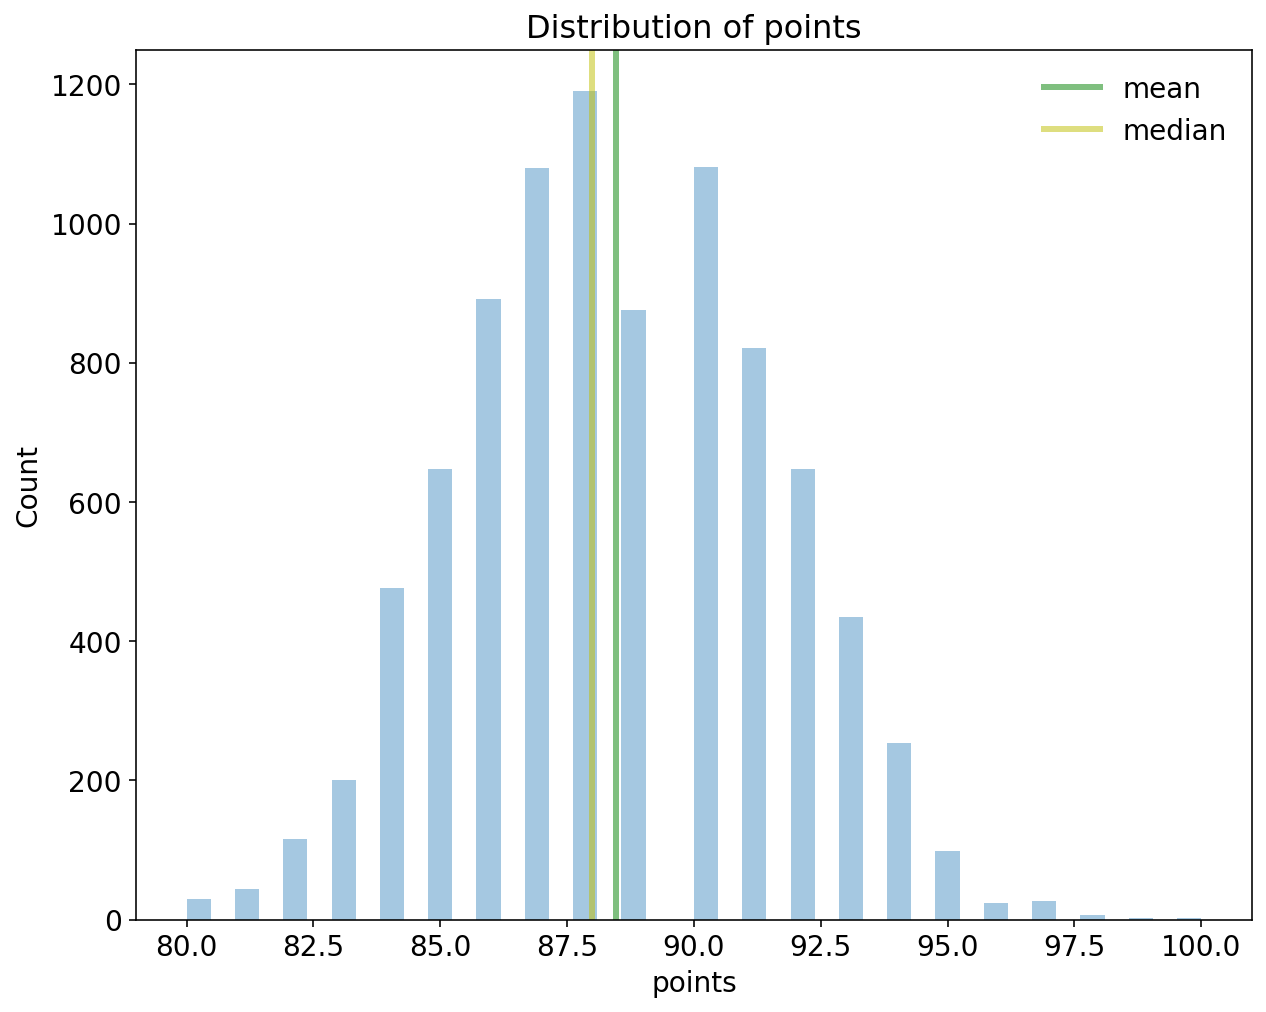

In [50]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, 'points')

*Wine points* show a *normal distribution* (a bell shaped curve obvious) as expected from a random variable. Range of *wine points* are distributed between 80 and 100 with the average (mean) of 88.45 and median (the middle value) of 88. Moreover, **standard deviation**, a measure of spread of a data range, is 3.03. 

Based on these statistics, we can confidently say that:

+ 68% of the points lie in the 85.5 - 91.5 range
+ 95% of the points lie in the 82.5 - 94.5 range
+ 99% of the points lie in the 79.5 - 97.5 range

*Alternatively, we can see the points as a classification of wines and interpret *wine points* as different classes according to wine searcher:

+ 98–100: Classic
+ 94–97: Superb
+ 90–93: Excellent
+ 87–89: Very good
+ 83–86: Good
+ 80–82: Acceptable

*However, this would be a different wine predictor, which is not my objective*

## 2.2 Distribution of price

Plotting a histogram for price variable

(0.0, 200.0)

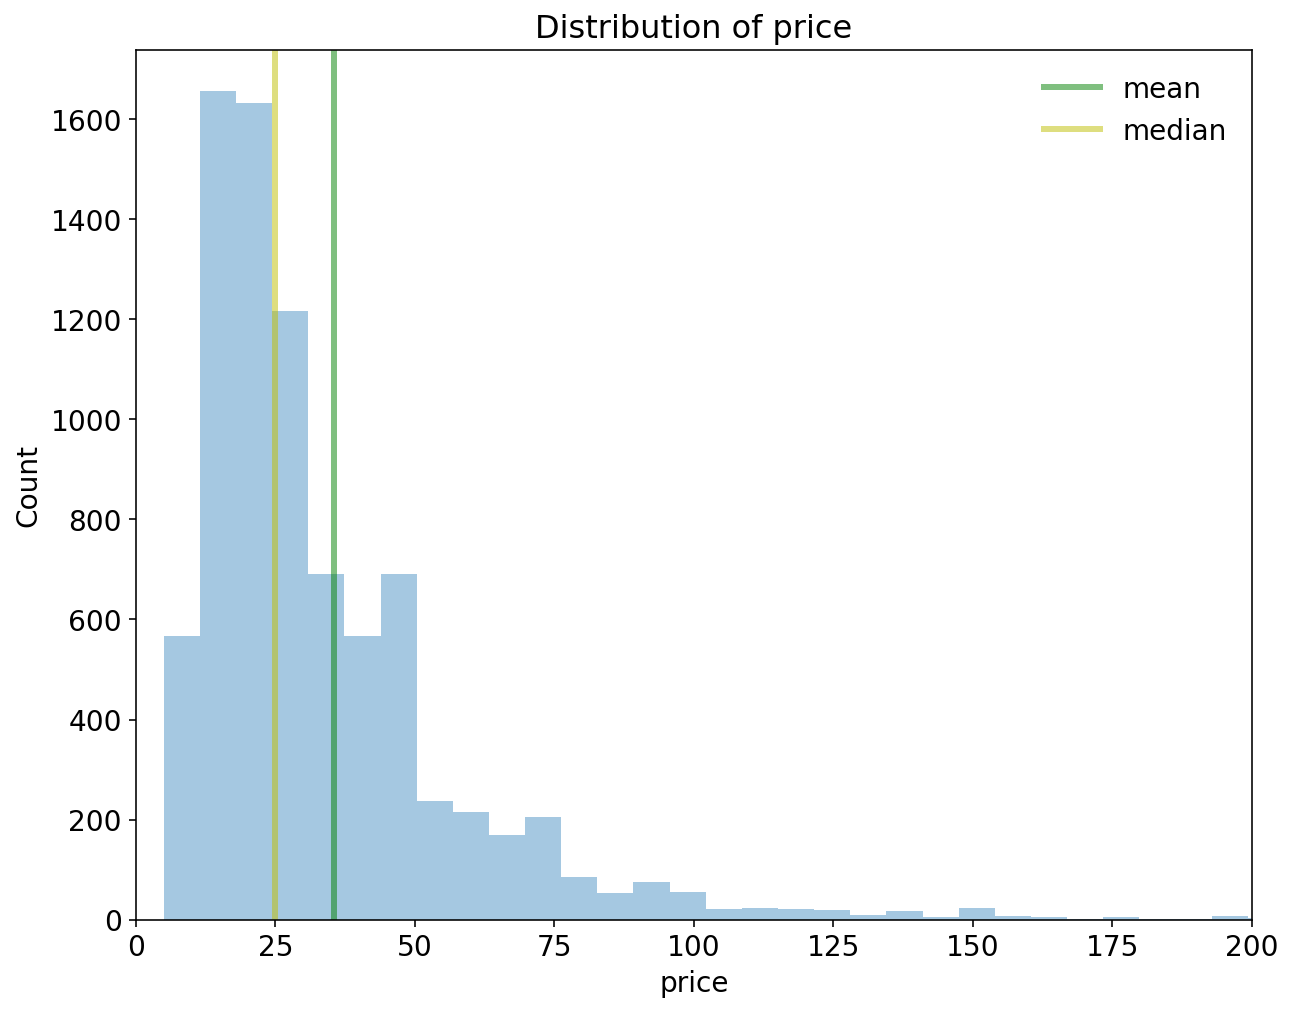

In [51]:
figsize(10, 8)
plt.rcParams['font.size'] = 14
plot_histogram(train_cleaned, 'price', 200)
plt.xlim(0, 200)

**Price** is concentrated between the range 0-200, which is defined as *right-skewed distribution*

This can be interpreted as the majority of wine are priced below 200 and most of them are a cheaper wine, explaining the spike near 0

This is also an indicator that we have a few very expensive wines, extending price to 1200

This gives us a better picture of **price distribution**. It is a right-skewed distribution as most of the price's are less than 50. Median of the price is 25 and the average price is 35.5

In order to use *price* as a predictor, *we need to assume that wine points received for a wine does not cause any price change*. Otherwise, *price* would cause data leakage which would spoil our future predictions of wiine

Nonetheless, *price* is an indicator of wine's quality and age, assuming it is not affected by the wine points received, it will be an important determiner for our model

## 2.3 Points Vs. Country

To visualize the **relationships of several variables**, we will use a **density plot** where we plot the distribution of target per unique values of a categorical feature

*A density plot can be interpreted as the continuous and smoothed version of a histogram which conveys the shape of the distribution easily*

To keep the plots interpretable, I will plot the distribution of points for the countries with more than 100 occurrences

In [0]:
# make a list of countries that has most occurences
countries = (train_cleaned["country"].value_counts())

freq_countries = list(countries[countries.values > 300].index)

freq2_countries = list(countries[(countries.values <= 300) & (countries.values >= 100)].index)

In [0]:
def plot_distribution(df, target, column_values, column_name):
  # funtion to print distribution of a continuous variable for categorical data

  for value in column_values:
      subset = df[df[column_name] == value]
      g = sns.kdeplot(subset[target],
                      label=value,
                      linewidth=3)

  # set title, legend and labels
  plt.ylabel('Density', size=14)
  plt.xlabel("{}".format(target), size=14)
  plt.title("Distribution of {} per {}".format(target, column_name), size=16)

  return g

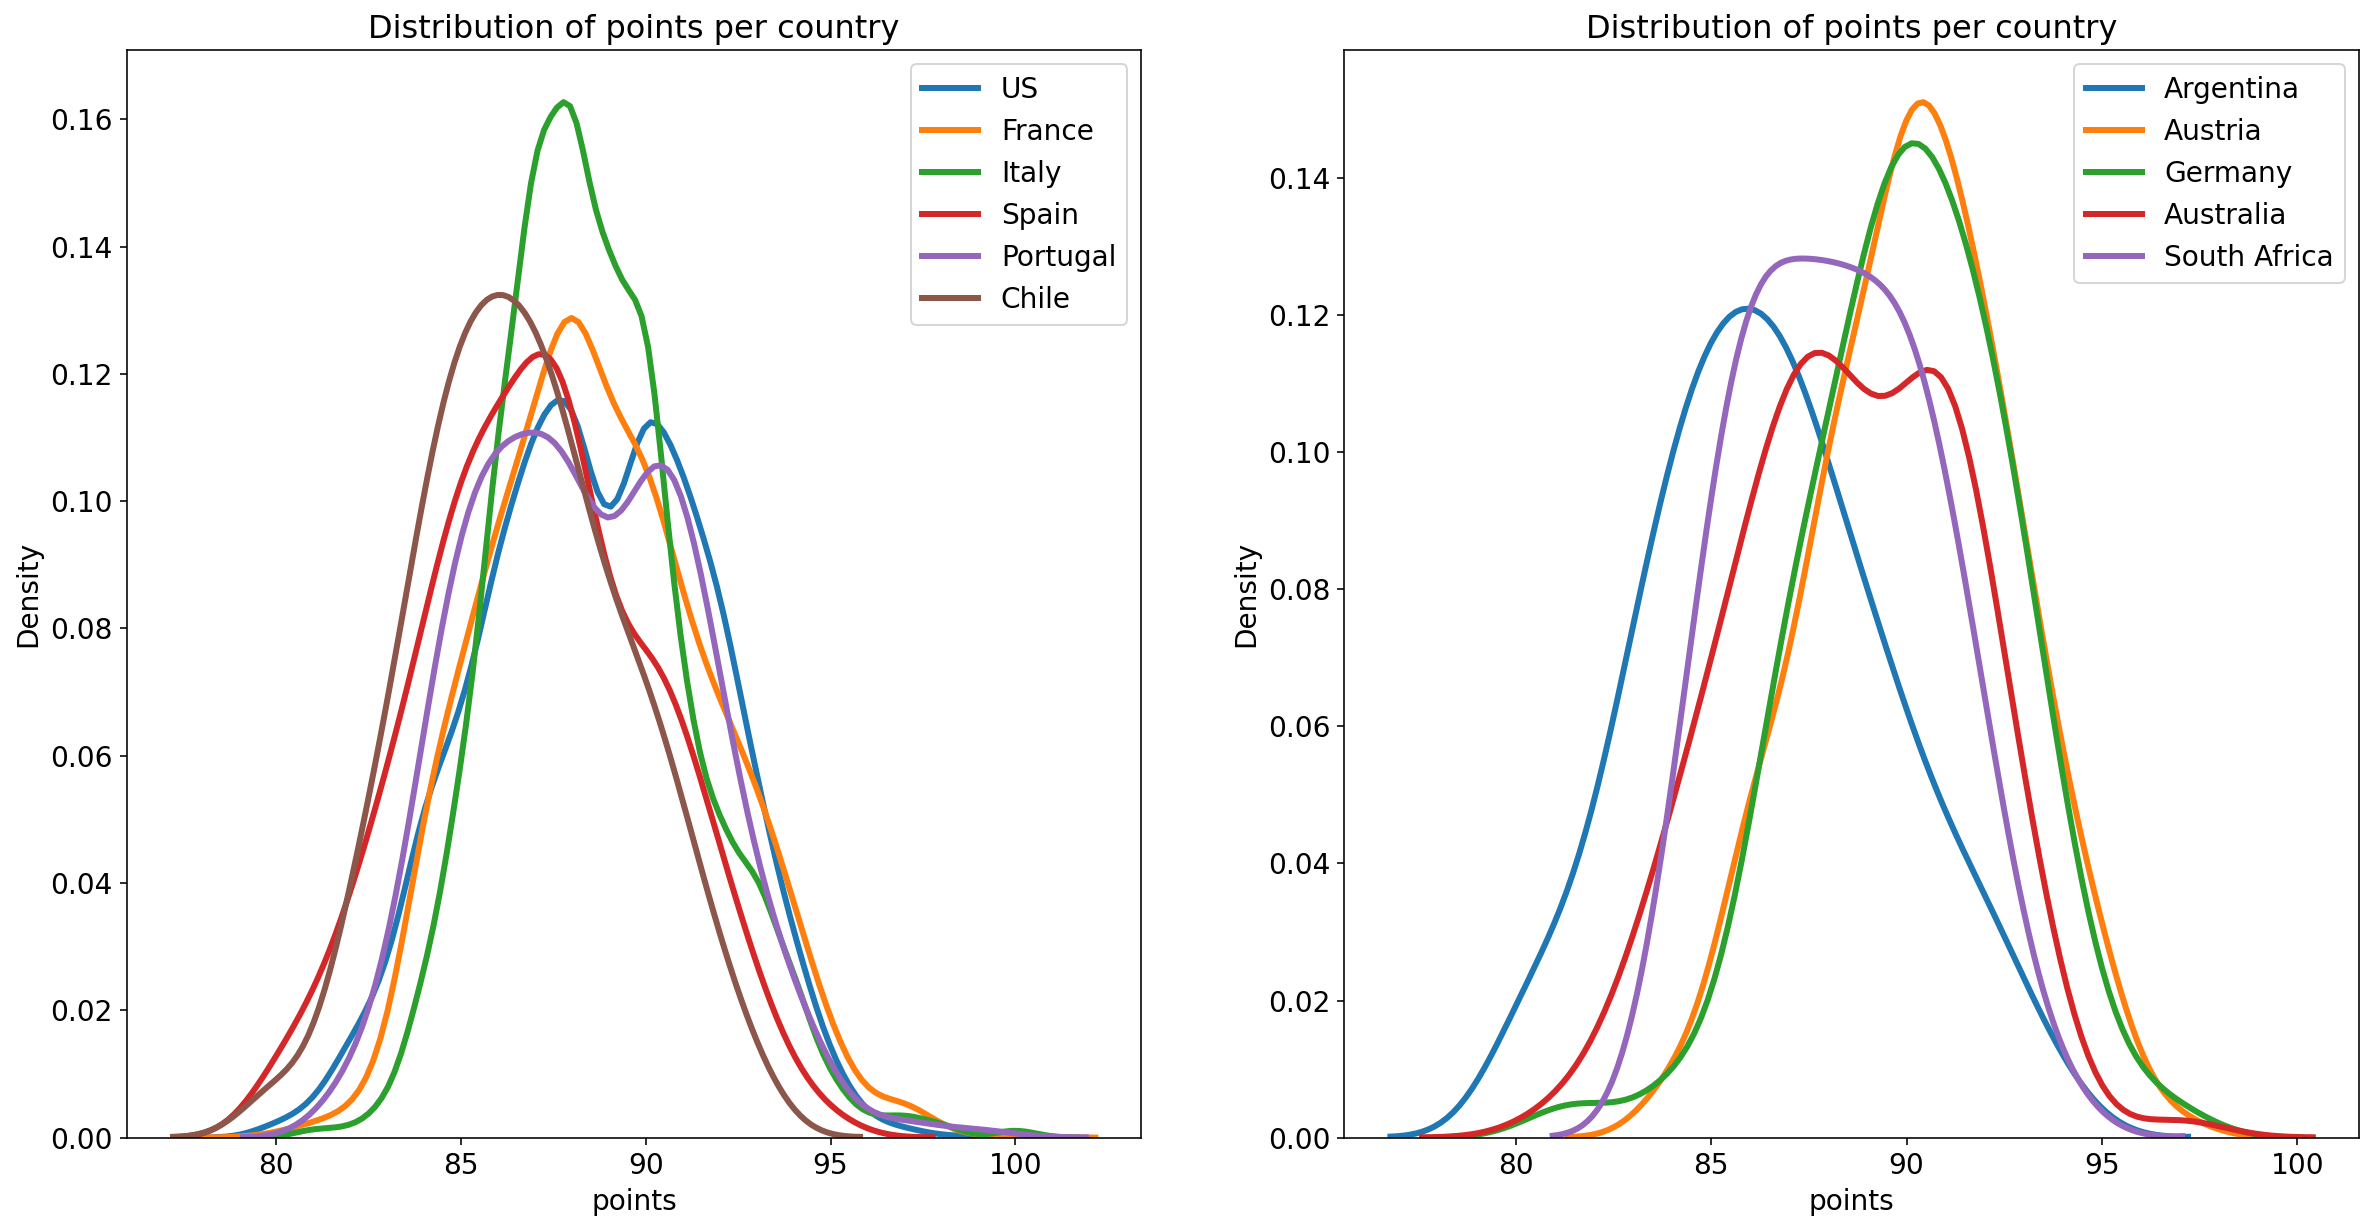

In [54]:
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot points distribution for most frequent countries
plt.subplot(1, 2, 1)
plot_distribution(train_cleaned, 'points', freq_countries, 'country')

plt.subplot(1, 2, 2)
plot_distribution(train_cleaned, 'points', freq2_countries, 'country')

Wine producing countries are dominated by US, France, Italy and Spain which are easily visible from the plots. In general, *country* is a differentiating feature to determine wine points. However, there are some exception, *country* pairs that have same wine points distribution:

+ USA - Portugal
+ Austria - Germany
+ Argentina - Chili

## 2.4 Points Vs. Price in most frequent countries
Assuming that the price is an essential determiner for the points, we will explore points and price relationship with country

(0.0, 200.0)

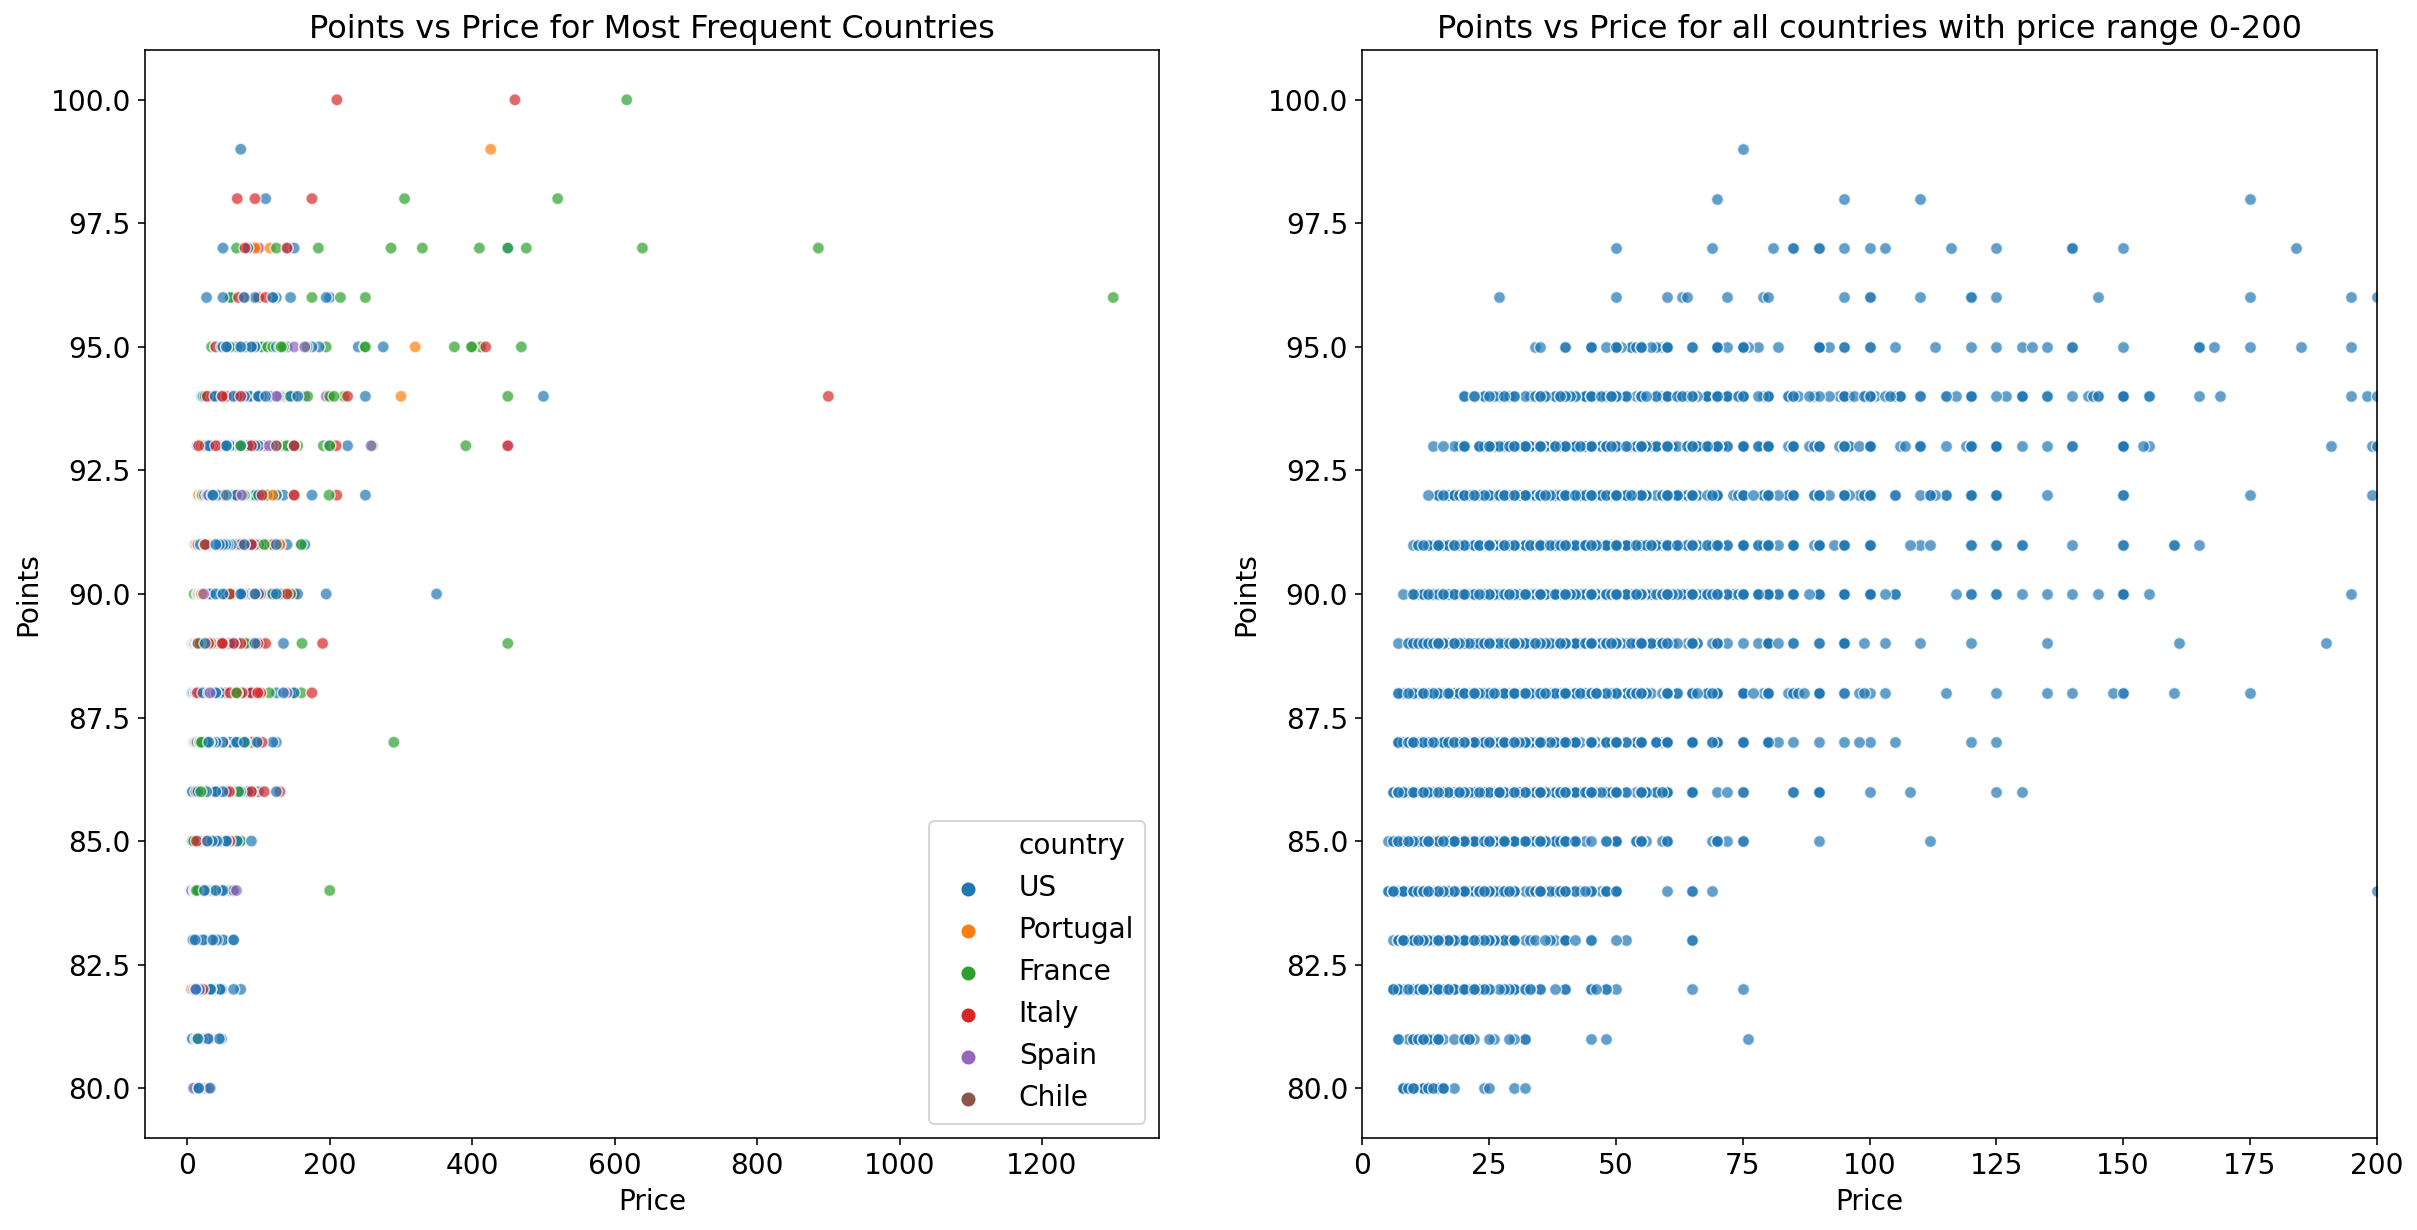

In [55]:
# create df of most frequent countries
points_freq_countries = train_cleaned[train_cleaned.country.isin(freq_countries)]
figsize(20, 10)
plt.rcParams['font.size'] = 14

# plot a scatterplot of Points and Price
plt.subplot(1,2,1)
sns.scatterplot(x='price', y='points',
                hue='country', 
                data=points_freq_countries,
                alpha=0.7)

plt.xlabel('Price', size=14)
plt.ylabel('Points', size=14)
plt.title('Points vs Price for Most Frequent Countries', size=16)

# plot a scatterplot of Points and Price
plt.subplot(1, 2, 2)
sns.scatterplot(x='price', y='points', 
                data=train_cleaned,
                alpha=0.7)

plt.xlabel('Price', size=14)
plt.ylabel('Points', size=14)
plt.title('Points vs Price for all countries with price range 0-200', size=16)
plt.xlim(0, 200)

## 2.5 Points Vs. Taster Name
Points, represents the *score* a particular wine received from a taster

So, a different taster might infer different interpretations of a wine

To investigate this I are going to plot a violin plot

Violin plot conveys the distribution of the data shape and summary statistics with the violins outside and slim rectangles inside respectively

Text(0.5, 1.0, 'Points from Different Tasters')

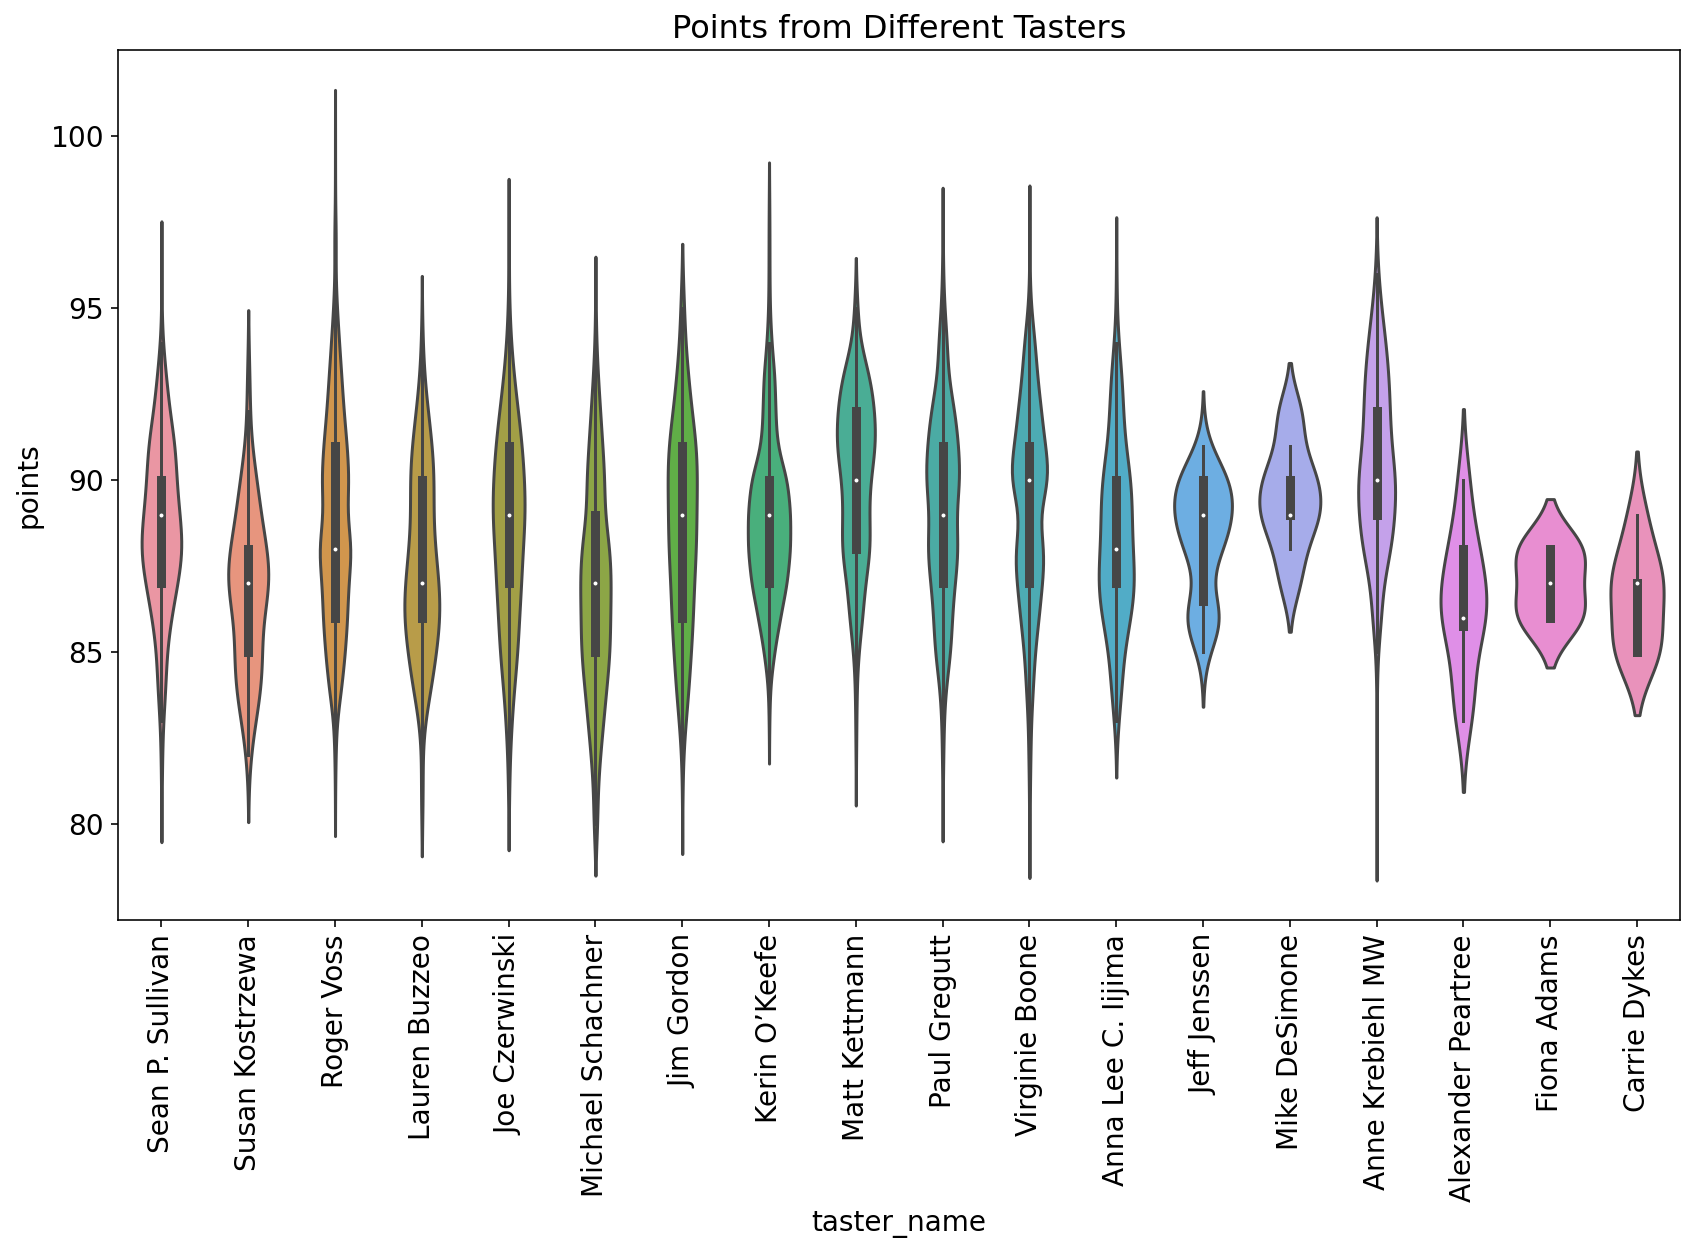

In [56]:
figsize(14, 8)
plt.rcParams['font.size'] = 14

f = sns.violinplot(data=train_cleaned,
                   x='taster_name',
                   y='points')

f.set_xticklabels(f.get_xticklabels(), rotation=90)

plt.title('Points from Different Tasters', size=16)

Violins shows the distribution of the points and their descriptive statistics together per taster. It's clear that each taster's descriptive statistics and distribution of points are unique

Looking at this picture, *taster_name* could be the 2nd most important predictor of points for a wine

# Our Findings from EDA

Points:
+ Points are normally distributed. Range of points are between 80 and 100
+ There are 3 wines that have points of 100
+ 99% of the points are between 79.5 - 97.5 with a mean of 88.5 and median of 88

Price:
+ Most of the wine prices are lower than 200 with a mean of 35.5 and median of 25
+ There is a positive correlation between the points of a wine and its price, making price an important feature

Country:
+ Distribution of points per country is mostly different with several exception country pairs

Taster name: 
+ Taster_name may be the 2nd most important feature in determining points since distribution, shape and descriptive statistics of a taster is unique



# 3. Feature Engineering & Feature Selection

Our feature engineering steps are as follows:

**Feature Extraction**:

+ from description: is_red, is_white, is_rose, is_dry, is_sweet and is_sparkling
+ from title: year
+ from variety: is_blend

**Categorical Feature Transformation**:

Categorical features (country, province, region_1, taster_name and variety) will be turned into numerical data, by using process of ordinal encoding

**Ordinal encoding** is the process of assigning positive integers consecutively to each unique value of a particular feature. Ordinal encoding approach is selected because of the possibility of having an unseen feature value in the test dataset

**Missing Value Imputation**:

+ taster_name: will be filled with constant value as 0, as it stands for "Unknown"
+ price and year: will be filled with median since median value is robust to outliers
+ country, province, region_1 and variety: will be filled with most_frequent value, since the most_frequent values of each feature aligns. They are: US, California, Napa Valley and Pinot Noir respectively


### Partition Data
Validation set should be large enough to detect differences between the models you are training; test set should be large enough to indicate the overall performance of the final model; training set, needless to say, the larger the merrier

**Training and Validation Split**:

Training dataset will be used for training the model. Training a model is the process of the model learning the patterns between the features and the target, and using them for further predictions. This process should be done by holding out a slice from the training set before input into the model. A held out part is called validation dataset and will be used as a measure of how well our model will generalize to a first-time-seen dataset. Moreover, this measure will be one of the selection criteria for our algorithm selection

**Save files to the "transformed" folder**:

Finally, our datasets will be ready to be inputed into any machine learning algorithm.

## 3.1 Feature extraction

+ description

Contains information about the wine’s colour, taste and notes (like sweet, dry)

Taste and colour-related words are searched and extracted from the description with the function below

If a taste or colour-related word exists in the description, the corresponding feature to that word is assigned with a value of 1, otherwise 0


In [0]:
def extract_features_from_description(df, 
                                      column_name,
                                      new_feature_name, 
                                      extract_words):
    # function to extract features from the column_name
    # searches column_name feature for a given list
    # ASSUMPTION: There is no NA values
    # in the description feature
    check_regex = (r'\b(?:{})\b'.format('|'.join(map(re.escape, extract_words))))

    df[new_feature_name] = (df[column_name].str.contains(check_regex, regex=True).astype('uint8'))
    return df

+ title

Contains the production year of the wine

If year information is not available in the title year, a 0 is assigned to it

In [0]:
def extract_year_from_title(title):
  # function to find the year in the given list
  # if not found assigns 0 as year
  # ASSUMPTION: There is no NA values
  # in the title feature
    
  int_list = []
  now = datetime.datetime.now()
    
  for item in title:
      int_list.append(int(item))
    
  for item in int_list:
      if item <= now.year and item >= 1900:
          return item
      else:
          return 0

+ variety

Contains information about whether different types of grapes are blended

*is_blend* is assigned to 1 if several grape varieties present, otherwise 0

In [0]:
def extract_blend_from_variety(variety):
  # function to find if a variety is a blend
  # ASSUMPTION: There is no NA values
  # in the variety feature
    
  if (variety.find('-') != -1) | (variety.find('Blend') != -1):
      if variety == 'Xarel-lo':
          return 0
      else:
          return 1
  else:
      return 0

In [0]:
# create search terms for new features 
# to be extracted from description
is_red_list = ['red', 'Red', 'RED',
               'noir', 'NOIR', 'Noir',
               'black', 'BLACK', 'Black']

is_white_list = ['white', 'WHITE', 'White',
                 'blanc', 'Blanc', 'BLANC',
                 'bianco', 'Bianco', 'BIANCO',
                 'blanco', 'Blanco', 'BLANCO',
                 'blanca', 'Blanca', 'BLANCA']

is_rose_list = ['rose', 'ROSE', 'Rose',
                'rosé', 'Rosé', 'ROSÉ']

is_sparkling_list = ['sparkling', 'SPARKLING', 'Sparkling']

is_dry_list = ['dry', 'Dry', 'DRY', 
               'dried', 'Dried', 'DRIED']

is_sweet_list = ['sweet', 'Sweet', 'SWEET']

desc_extracting_dict = {
    'is_red': is_red_list,
    'is_white': is_white_list,
    'is_rose': is_rose_list,
    'is_sparkling': is_sparkling_list,
    'is_dry': is_dry_list,
    'is_sweet': is_sweet_list
    }

In [0]:
def ExtractFeatures(df):
  # adds is_red, is_white, is_rose, is_rose
  # is_sparkling, is_dry, is_sweet
  for key, value in desc_extracting_dict.items():
    interim_df = extract_features_from_description(df, 'description', key, value)

  # adds year
  interim_df['title_numlist'] = (interim_df.title.str.findall(r'\b\d+\b'))

  interim_df['year'] = (interim_df.title_numlist.apply(extract_year_from_title))

  # adds is_blend
  interim_df['is_blend'] = (interim_df.variety.apply(extract_blend_from_variety))
  
  # drop unused features
  features_added_df = (interim_df.drop(columns=['description', 'title', 'title_numlist']))
  
  return features_added_df

In [0]:
train_features_added = ExtractFeatures(train_cleaned)
test_features_added = ExtractFeatures(test_cleaned)

## 3.2 Feature transformation

This part turns categorical features *(country, province, region_1, taster_name and variety)* into numerical features using **ordinal encoding approach**

*Remember that this is a sample dataset, so we have to consider the possible values that are not present in this sample dataset but may show up in the test dataset*

Hence, the use of *ordinal encoder*


When we set *handle_unknown* parameter to the "value", the ordinal_encoder object will assign the first-time seen values of the test set to -1

Then, we run fit method on the training set, ordinal_encoder object maps the values of the given features to the integers

Then, we run transform method on both datasets, the transformation process is completed according to mapping done during fitting and we get full-numeric features in return

In [0]:
ordinal_encode_cols = ['country', 'province',
                       'region_1', 'taster_name', 'variety']

In [0]:
def EncodeCategoricalData(train_df, 
                          test_df, 
                          cols=ordinal_encode_cols):
  # funtion to create ordinal encoder object and
  # assigns -1 to the unseen labels of the test set
  # returns ordinal encoded train and test datasets
  # respectively

  ordinal_encoder = OrdinalEncoder(cols=ordinal_encode_cols,
                                   return_df=True,
                                   handle_unknown='value',
                                   handle_missing='return_nan')
  ordinal_encoder.fit(train_df)
    
  ord_encoded_train = (ordinal_encoder.transform(train_df))
    
  ord_encoded_test = (ordinal_encoder.transform(test_df))

  return ord_encoded_train, ord_encoded_test

## 3.3 Categorical value transformation
Ordinal encoder object from category_encoders library will enable us to handle effectively non-present values of the features that might arise in the test set. When a non-present value is encountered in the test set, it will be assigned to -1

In [0]:
ordinal_encode_cols = ['country', 'province', 'region_1', 'variety',  'taster_name']
data_encoded = EncodeCategoricalData(train_features_added, test_features_added)

train_encoded = data_encoded[0]
test_encoded = data_encoded[1]

+ taster_name

As we expect *taster_name* to be one of the most important features, it is imputed with a constant value

(0 stands for “Unknown taster”)

That way, we can maintain each taster’s effect in determining points

In [0]:
def ImputeWithConstant(train_df, test_df, cols=['taster_name']):
  # function to impute taster_name
  # with 0 stands for 'Unknown value'

  train_df = pd.DataFrame(train_df[cols])
  test_df = pd.DataFrame(test_df[cols])

  constant_imputer = SimpleImputer(strategy='constant', fill_value=0)

  constant_imputer.fit(train_df)
    
  imputed_train_set = constant_imputer.transform(train_df)
  imputed_train_df = pd.DataFrame(imputed_train_set, columns=train_df.columns)

  imputed_test_set = constant_imputer.transform(test_df)
  imputed_test_df = pd.DataFrame(imputed_test_set, columns=test_df.columns)

  return imputed_train_df, imputed_test_df

+ price and year

Imputed with median value since they are **numeric features** and the median is not affected by the extreme values


In [0]:
def ImputeWithMedian(train_df, test_df, cols=['price', 'year']):
  # function to impute price and year
  # columns with the median value of each 
  # median imputer is fitted on train set
  # transformation done on the train and test set

  train_df = pd.DataFrame(train_df[cols])
  test_df = pd.DataFrame(test_df[cols]) 
    
  median_imputer = SimpleImputer(strategy='median')

  median_imputer.fit(train_df)
    
  imputed_train_set = median_imputer.transform(train_df)
  imputed_train_df = pd.DataFrame(imputed_train_set, columns=train_df.columns)

  imputed_test_set = median_imputer.transform(test_df)
  imputed_test_df = pd.DataFrame(imputed_test_set, columns=test_df.columns)

  return imputed_train_df, imputed_test_df

+ country, province, region_1 and variety

Imputed with most frequent value since they are **categorical features** and the most frequent values of each feature align

Those are US, California, Napa Valley and Pinot Noir respectively

In [0]:
def ImputeWithMostFrequent(train_df, test_df, cols=['country', 'province', 'region_1', 'variety']):
  # function to impute country, province, region_1, variety
  # columns with the most_frequent value of each feature
  # most_frequent imputer is fitted on train set
  # transformation done on the train and test set

  train_df = pd.DataFrame(train_df[cols])
  test_df = pd.DataFrame(test_df[cols]) 
    
  most_frequent_imputer = SimpleImputer(strategy='most_frequent')

  most_frequent_imputer.fit(train_df)
    
  imputed_train_set = most_frequent_imputer.transform(train_df)
  imputed_train_df = pd.DataFrame(imputed_train_set, columns=train_df.columns)

  imputed_test_set = most_frequent_imputer.transform(test_df)
  imputed_test_df = pd.DataFrame(imputed_test_set, columns=test_df.columns)

  return imputed_train_df, imputed_test_df

One important consideration during imputing is, whatever imputing strategy is selected, both training and test sets are imputed with the same values

For instance, the median of the price in the training set is 25 and this value is assigned to missing values of the training set and the test set to prevent **data leakage** into the test set


## 3.4 Missing value imputation
For imputation, scikit-learn's simple imputer will be used

In [0]:
def ImputeMissingValues(train_df, test_df):
    # separete non-NA cols
    is_features = [col for col in train_df.columns
                   if col.find('is_') != -1]
    
    interim_train_1 = train_df[is_features]
    interim_test_1 = test_df[is_features]

    # impute taster_name NA with 0 as "Unknown"
    constant_impute = ImputeWithConstant(train_df, test_df)
    
    interim_train_2 = constant_impute[0]
    interim_test_2 = constant_impute[1]

    # impute year and price with median
    median_impute = ImputeWithMedian(train_df, test_df)
    
    interim_train_3 = median_impute[0]
    interim_test_3 = median_impute[1]

    # impute country, province, region_1,
    # variety with most_frequent
    most_frequent_impute = ImputeWithMostFrequent(train_df, test_df)
    
    interim_train_4 = most_frequent_impute[0]
    interim_test_4 = most_frequent_impute[1]

    train_features = (interim_train_4.join(interim_train_3).join(interim_train_2).join(interim_train_1))
    train_target = pd.DataFrame(train_df['points'])

    test_features = (interim_test_4.join(interim_test_3).join(interim_test_2).join(interim_test_1))
    test_target = pd.DataFrame(test_df['points'])

    return train_features, train_target, test_features, test_target

In [0]:
transformed_data = ImputeMissingValues(train_encoded, test_encoded)

train_features = transformed_data[0]
train_target = transformed_data[1]
test_features = transformed_data[2]
test_target = transformed_data[3]

### Creating Validation set by separating 25% of our training set randomly

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(train_features,
                                                      train_target, 
                                                      test_size=0.25, 
                                                      random_state=42)

### Training and validation set split

In [0]:
# create validaiton set
X_train, X_valid, y_train, y_valid = train_test_split(
    train_features, 
    train_target, 
    test_size=0.25, 
    random_state=42)

### Ensure training, validation, & test sets shapes align and no missing values exists

In [73]:
# display sizes of data
print('Training Features Size:  ', X_train.shape)
print('Validation Features Size:  ', X_valid.shape)
print('Training Target Size:  ', y_train.shape)
print('Validation Target Size:  ', y_valid.shape)
print('Test Features Size:  ', test_features.shape)
print('Test Target Size:  ', test_target.shape)

Training Features Size:   (6711, 14)
Validation Features Size:   (2237, 14)
Training Target Size:   (6711, 1)
Validation Target Size:   (2237, 1)
Test Features Size:   (1000, 14)
Test Target Size:   (1000, 1)


In [74]:
# make sure no NA values
print('Number of missing values in X_train: ', X_train.isna().any().sum())
print('Number of missing values in X_valid: ', X_valid.isna().any().sum())
print('Number of missing values in y_train: ', y_train.isna().any().sum())
print('Number of missing values in y_valid: ', y_valid.isna().any().sum())
print('Number of missing values in test_features: ', test_features.isna().any().sum())
print('Number of missing values in test_target: ', test_target.isna().any().sum())

Number of missing values in X_train:  0
Number of missing values in X_valid:  0
Number of missing values in y_train:  0
Number of missing values in y_valid:  0
Number of missing values in test_features:  0
Number of missing values in test_target:  0


### Save files to the folder under notebooks
Let's save our dataframes which are ready to be used as an input for our machine learning models and continue with the model selection in the second notebook

In [0]:
#X_train.to_csv('transformed/X_train.csv', index=False)
#X_valid.to_csv('transformed/X_valid.csv', index=False)

#y_train.to_csv('transformed/y_train.csv', index=False)
#y_valid.to_csv('transformed/y_valid.csv', index=False)

#test_features.to_csv('transformed/test_features.csv', index=False)
#test_target.to_csv('transformed/test_target.csv', index=False)

![](https://drive.google.com/uc?id=1vu0AnrqIi-OK_3u8kd0BNCgCmtLfZ5iw)